# Model GARCH

## 1. GARCH with theta given

### UQSA for GARCH
we need to calculte the $$H(x, r_t) = \frac{1}{|\tilde\theta|}A^T\left(\sum_{k=1}^H r_{T_{\text{reb}}+k}r^T_{T_{\text{reb}}+k}\right)(Ax+b),$$
from the $r_{T_{\text{reb}}}$ given. Then things goes easy to perform almost the same thing like what we have done with the toy model.

To begin with, we simply take $H = 1$ and we fix the $\theta$ parameters.
$$w(x)=(x_1, x_2, ... x_{n-1}, 1-\sum_i^{n-1}x_i)^T = Ax+b,$$
where
$$
A 
= 
\begin{pmatrix} 
1 & 0 & \cdots & 0\\
0 & 1 & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
0 & \cdots & 0 & 1 \\
-1 & -1 & \cdots & -1
\end{pmatrix}_{n\times(n-1)},
b = (0,\, 0,\,\cdots,0,\,1)^T\in \mathbb{R}^{n}
$$

In [73]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def plot_trace(h,y=None):
    l = np.shape(h)[0]
    hh = np.array(h)
    plt.plot(hh[:l,0],label= 'Robbins Monro results')
    if y:
        plt.hlines(y = y,xmin=0,xmax=10000,colors='red',label='Theory answer')
    plt.ylim(-1.,1.)
    plt.legend(loc = 'best')
    plt.show()

In [99]:
np.random.seed(123)
corr = np.diag(np.ones(n))
for i in range(n):
    for j in range(i+1, n):
        corr[i, j] = corr[j, i] = np.random.uniform(-0.2, 0.8)
corr
e, v = scipy.linalg.eigh(corr)

array([[1.        , 0.49646919, 0.08613933, 0.02685145],
       [0.49646919, 1.        , 0.35131477, 0.51946897],
       [0.08613933, 0.35131477, 1.        , 0.22310646],
       [0.02685145, 0.51946897, 0.22310646, 1.        ]])

In [100]:
import scipy.linalg
e, v = scipy.linalg.eigh(corr)
e

array([0.2792889 , 0.79608681, 1.0112754 , 1.91334889])

In [101]:
n = 4

unit = np.identity(n-1)
ones = np.ones((1, n-1))
A = np.vstack((unit, -ones))
b = np.vstack((np.zeros((n-1,1)), [[1]]))
theta = np.array([1.35e-6, 0.0622, 0.9306])
R0 = np.random.randn(n,1)
sig_mu = 1.77e-4
sig_vol=1.44e-4
sigma2_0 = np.random.randn(n,1)*sig_vol+sig_mu
Gamma = corr
theta_min = [3.2e-9,0.0329,0.8855]
theta_max = [4.32e-6,0.0955,0.9656]
the = np.array([theta_max[i] - theta_min[i] for i in range(3)])*np.random.uniform(size = (n,3)) + np.array(theta_min)
theta = the.T
A, b

(array([[ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [-1., -1., -1.]]),
 array([[0.],
        [0.],
        [0.],
        [1.]]))

In [102]:
def H_garch(x, R, theta):
    """
    function for Robbins Monro regression for GARCH model
        E[f2(w(x),R)] = F^r(w(x)) = 0 
        Note that A is of dim (d,d-1) (d = n = len(R_))
    inputs :
            x :   n-1 vector in the regression
            R :   A random vector to perform the RM
        theta :   generate parameter given
    return : f(w,R) of dimension n-1
    """
    x_, R_= x.reshape(n-1,1), R.reshape(n, 1)
    
    left = np.matmul(A.T, np.matmul(R_, R_.T))
    right = np.matmul(A, x) + b
    
    result = np.matmul(left, right)
    
    return result/np.max(np.linalg.norm(theta,axis = 0))

In [128]:
def R_simulator(R0, sigma2_0, theta, Gamma, N):
    """
    n is the number of stocks/ dim of sigma
    
    Inputs:
        R0       : R_pre np.array of shape (n,1)
        sigma2_0 : sigma_pre np.array of shape (n,1)
        theta    : theta fixed in the RM model (3,n)
        Gamma    : positive defini matrix of dimension (n,n)
        N        : number of exemple we need
    
    Return:
        Rs       : matrix of dimension (n,N) of which each colume is a simulated new R
    """
    ones = np.ones((n,1))
    g = np.hstack((ones, R0**2, sigma2_0))  # n,3
    sigma2 = g.dot(theta)
    D = np.diag(np.sqrt(np.diag(sigma2)))
    eta = np.sqrt(Gamma).dot(np.random.randn(n,N))  
    return D.dot(eta)

In [125]:
ones = np.ones((n,1))
g = np.hstack((ones, R0**2, sigma2_0))  # n,3
sigma2 = g.dot(theta)
D = np.sqrt(np.diag(sigma2))
np.diag(D)

array([[0.50842204, 0.        , 0.        , 0.        ],
       [0.        , 0.11626044, 0.        , 0.        ],
       [0.        , 0.        , 0.33822689, 0.        ],
       [0.        , 0.        , 0.        , 0.20447008]])

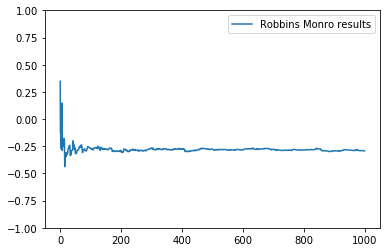

final result is 
 [[-0.29238353]
 [ 2.06913591]
 [-0.11047732]
 [-0.66627505]]


In [169]:
def RM_bis(N = 10000, alpha = 0.6):
#     R = np.random.multivariate_normal(mu, S, N)
    Rs = R_simulator(R0 = R0,sigma2_0=sigma2_0,theta=theta,Gamma=Gamma,N=N)
    x = np.random.random((n - 1, 1)) # initialization with random value
#     print(Rs.shape)
    w0 = np.vstack((x, 1 - np.sum(x)))
    w = [w0]
    w_hist = [w0.reshape(n, 1)]
    
    rg = range(N)
    if N > 1e4 :
        rg = tqdm(rg)
        
    for i in rg:
        x = x - 10.*H_garch(x, Rs[:,i],theta)/np.power(i+1, alpha)
        w_tmp = np.vstack((x, 1 - np.sum(x)))
        w.append(w_tmp)
        w_hist.append(w_tmp/np.sum(w_tmp))
        
    plot_trace(w_hist)
    
    print("final result is \n {}".format(w[-1]/np.sum(w[-1])))
#     print("compare with the theory result \n {}".format(theory_answer(S)))
    return w[-1]/np.sum(w[-1]),w,w_hist
x,_,_ = RM_bis(N = 1000,alpha = 0.65)

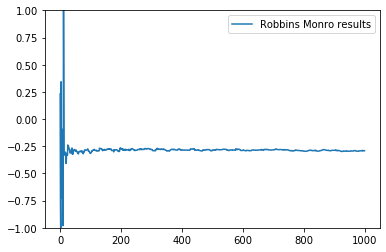

final result is 
 [[-0.29101275]
 [ 2.07917871]
 [-0.10140921]
 [-0.68675675]]


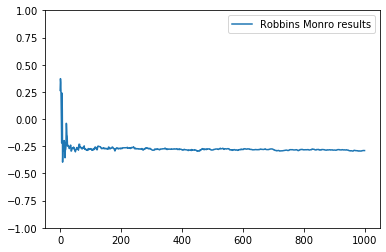

final result is 
 [[-0.28954869]
 [ 2.06025821]
 [-0.10684241]
 [-0.66386711]]


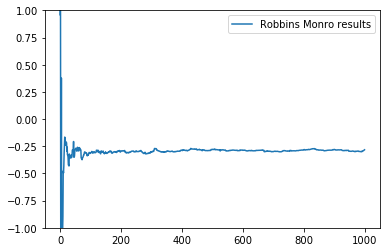

final result is 
 [[-0.28239095]
 [ 2.09339462]
 [-0.10735035]
 [-0.70365332]]


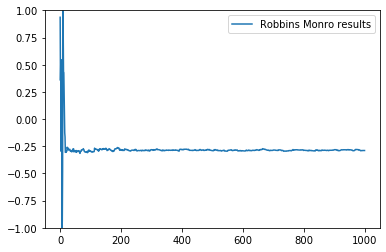

final result is 
 [[-0.2890676 ]
 [ 2.08280637]
 [-0.11275735]
 [-0.68098142]]


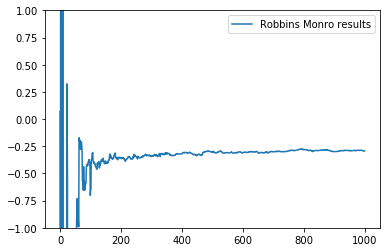

final result is 
 [[-0.29244919]
 [ 2.12323522]
 [-0.09673136]
 [-0.73405467]]


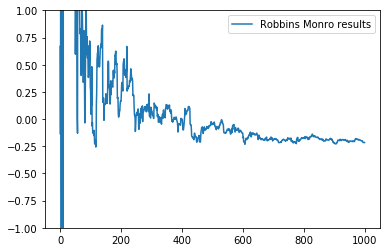

final result is 
 [[-0.21548733]
 [ 1.54883445]
 [-0.18835512]
 [-0.144992  ]]


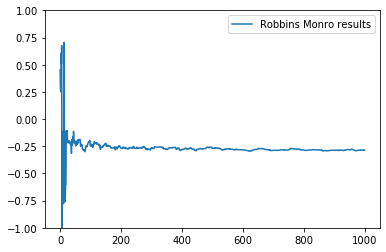

final result is 
 [[-0.28637837]
 [ 2.06024461]
 [-0.10442106]
 [-0.66944518]]


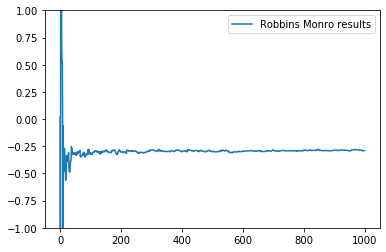

final result is 
 [[-0.28986232]
 [ 2.0903218 ]
 [-0.10778754]
 [-0.69267194]]


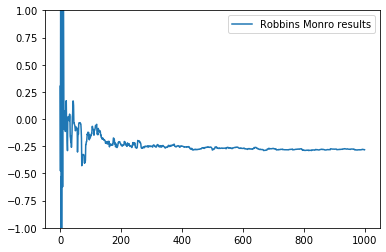

final result is 
 [[-0.28215769]
 [ 2.04433561]
 [-0.11920462]
 [-0.64297331]]


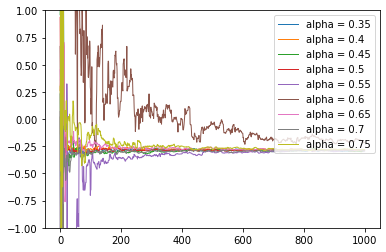

In [160]:
to_plot = []
for alp in np.arange(0.35,0.8,0.05):
    _,_,w_hist = RM_bis(N = 1000,alpha = 0.65)
    to_plot.append(w_hist)
l = np.shape(to_plot[0])[0]
#     l = np.shape(h)[0]
#     hh = np.array(h)
labels = [0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8]
for i,w_hist in enumerate(to_plot):
    h = np.array(w_hist)
    plt.plot(h[:l,0],label='alpha = {}'.format(labels[i]),linewidth=1)
# plt.plot(hh[:l,0],label= 'Robbins Monro results')
plt.ylim(-1.,1.)
plt.legend(loc = 'upper right')
plt.show()

In [147]:
test = np.arange(0.35,0.8,0.05)
test

array([0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75])

In [78]:
def para_simulate(n,theta,r_init,sig_init,GAMMA):
    """
    To comment!!!
    """
    r_pre = r_init.reshape(n,1)
    sig_pre = sig_init.reshape(n,1)
    ones = np.eye(n)
    D_t_pre = np.diag(sig_pre)
    R_t_pre = np.diag(r_pre)
    rts = []
    for h in range(1,2):
        D_t_2 = ones*the[:,0] + the[:,1]*R_t_pre**2 + the[:,2]*D_t_pre**2
        D_t = np.sqrt(D_t_2)
        V_t = D_t.dot(GAMMA).dot(D_t)
        r_t = np.random.multivariate_normal(np.zeros(n), V_t)
        rts.append(r_t)
        D_t_pre = D_t
        R_t_pre = np.diag(r_t)
    return the,rts

## 2. GARCH with UQSA

### 2.1 H=1 case

we need to calculte the $$H(x, r_t) = \frac{1}{1+|\tilde\theta|^2}A^T\left(\sum_{k=1}^H r_{T_{\text{reb}}+k}r^T_{T_{\text{reb}}+k}\right)(Ax+b),$$
from the $r_{T_{\text{reb}}}$ given. Then things goes easy to perform almost the same thing like what we have done with the toy model.

TODO LIST:
- [x] Write the new function $$H(x, r_ts)$$ where $r_ts \in \mathcal{R}^{d*H}$ of which each coloum is an array with dimension $d$ for time $T_{\text{reb}}+k$
- [ ] Modify the part at the beginning of the self.iteration of the simulation part. what we need is a series of $\theta$s and $r_t$ arrays
- [ ] Modify the u_0initialization part
- [ ] Test for debugging and choosing good prameters.

In [ ]:
class UQSA_GARCHCCC:
    def __init__(self,K,n = 4, r_min = 0.3, r_max = 0.5, gamma = None,m = None,M = None,a = None,b=None,plot = False,
                theta_min = None,theta_max = None):
        """
        Class for the construction of UQSA generator
        
        ATTENTION:
                    - n     : dimention of \omega i.e. final solution
                    - n_iter: iteration help n, i.e. number of u_i iterated by UQSA
                    - LB    : reduced Legendre basis, with \int_{r_min}^{r_max}B_i(.)B_j(.)d\theta = \delta_{ij}
        """
        self.K = K
        # steps of iteration -------------------
        if gamma is not None:
            self.gamma = gamma
        elif b is not None:
            self.gamma = [1./np.power(k,b) for k in range(K+1)]
        else:
            self.gamma = [1./np.power(k,0.65) for k in range(K+1)]
        if not a:
            a=0.24
        self.m = [int(np.floor(np.power(k, a))) + 1 for k in range(K+1)]
        self.M = [10]*(K+1) if not M else M
        self.u0 = None
        self.u_record = None
        self.theta_min = [3.2e-9,0.0329,0.8855] if not theta_min else theta_min
        self.theta_max = [4.32e-6,0.0955,0.9656] if not theta_max else theta_max
        self.n = n                # n is the dimension of w and theoretically
#         self.n_iter = n_iter      # n_iter is the dimension of MC iteration for exemple if we take w_{n} = 1 - sum_1^{n-1}(w_{i}), then n_iter = n-1
        self.LB = None
        self.plot = plot          # Flag for plot
        #         self.LB = [np.sqrt((2*i+1)/(self.r_max-self.r_min))*np.polynomial.legendre.Legendre.basis(deg=i,domain=np.array([r_min, r_max])) for i in range(np.max(self.m)+1)]
        """
        n = 4
        unit = np.identity(n-1)
        ones = np.ones((1, n-1))
        A = np.vstack((unit, -ones))
        b = np.vstack((np.zeros((n-1,1)), [[1]]))
        theta = np.array([1.35e-6, 0.0622, 0.9306])
        R0 = np.random.randn(n,1)
        sig_mu = 1.77e-4
        sig_vol=1.44e-4
        sigma2_0 = np.random.randn(n,1)*sig_vol+sig_mu
        Gamma = corr
        theta_min = [3.2e-9,0.0329,0.8855]
        theta_max = [4.32e-6,0.0955,0.9656]
        the = np.array([theta_max[i] - theta_min[i] for i in range(3)])*np.random.uniform(size = (n,3)) + np.array(theta_min)
        theta = the.T
        A, b
        """
    def Legendre_B(self,a, b, n):
        """
        generate a normalized Legendre basis in the interval [a, b]
        n is the number of the Legendre basis needed
        """
        delta = b-a
        LB = [np.sqrt((2*i+1)/delta)*np.polynomial.legendre.Legendre.basis(deg=i) for i in range(n)]
        new = []
        for i in range(n):
            z = lambda x, i=i: LB[i]((2*x-a-b)/(b-a))
            new.append(z)
        return new
    def get_Gamma(self):
        np.random.seed(123)
        while True:
            corr = np.diag(np.ones(n))
            for i in range(n):
                for j in range(i+1, n):
                    corr[i, j] = corr[j, i] = np.random.uniform(-0.2, 0.8)
            if np.min(scipy.linalg.eigh(corr)[0])>0:
                return corr

    def f(self, x, R, theta):
        """
        function for Robbins Monro regression for GARCH model
            E[f2(w(x),R)] = F^r(w(x)) = 0 
            Note that A is of dim (d,d-1) (d = n = len(R_))
        inputs :
                x :   n-1 vector in the regression
                R :   A random vector to perform the RM
            theta :   generate parameter given
        return : f(w,R) of dimension n-1
        """
        x_, R_= x.reshape(n-1,1), R.reshape(n, 1)

        left = np.matmul(A.T, np.matmul(R_, R_.T))
        right = np.matmul(A, x) + b

        result = np.matmul(left, right)

        return result/np.max(np.linalg.norm(theta,axis = 0)) ##TODO!
    
    def W(self,m_k, rho, u0):
        return np.sum([u0[j]*self.LB[j](rho) for j in range(m_k+1)], axis = 0)
    
#     def S_rho(self, rho):
#         D = np.diag([.1, .14, .2])
#         # rho = 0.5
#         K = np.array([[1, rho, 0],
#                      [rho, 1, rho],
#                      [0, rho, 1]])
#         S = np.matmul(np.matmul(D, K), D)
#         return S
    
    def u0_initialization(self):
        n = self.n_iter #attention!!!
        unit = np.identity(n)
        ones = np.ones((1, n))
        self.A = np.vstack((unit, -ones))
        self.b = np.vstack((np.zeros((n,1)), [[1]]))
        ###########################
#                   MC
        ###########################
        u0_init = []
        rss = np.linspace(self.r_min,self.r_max,101)
        for i in range(np.max(self.m) + 1):
            u0_init_i = []
            for j in range(n):
                summ = 0.0
                for r in rss:
                    summ += self.omega_theory(r)[j] * self.LB[i](r)*1e-2 *0.2 
                u0_init_i.append(summ[0])  #MC Expectation = \int w(r)B_i(r) \pi(d\theta) et \pi(d\theta) = 0.2*d\theta in this case
            u0_init.append(u0_init_i)
            
        self.u_record = [u0_init]
        self.u0 = u0_init
        return self.u_theory_result
        
    def para_simulate(self):
        """
        To comment!!!
        """
        n = self.n
        the = np.array([self.theta_max[i] - self.theta_min[i] for i in range(3)])*np.random.uniform(size = (n,3)) + np.array(self.theta_min)
        r_pre = self.r_init.reshape(n,1)
        sig_pre = self.sig_init.reshape(n,1)
        ones = np.eye(n)
        D_t_pre = np.diag(sig_pre)
        R_t_pre = np.diag(r_pre)
        rts = []
        for h in range(1,H+1):
            D_t_2 = ones*the[:,0] + the[:,1]*R_t_pre**2 + the[:,2]*D_t_pre**2
            D_t = np.sqrt(D_t_2)
            V_t = D_t.dot(self.GAMMA).dot(D_t)
            r_t = np.random.multivariate_normal(np.zeros(n), V_t)
            rts.append(r_t)
            D_t_pre = D_t
            R_t_pre = np.diag(r_t)
        return the,rts
    
    def iteration(self):
        u0 = np.array(self.u0)
#         u0 = np.random.randn(np.shape(u0)[0],np.shape(u0)[1])
        n = self.n_iter
        for k in range(1, self.K+1):
            theta = []
            r_ts_set = []
            for _ in range(self.M[k]+1):
                the,rts = para_simulate()
                theta.append(the)
                r_ts_set.append(rts)
#                 r = np.random.uniform(low = self.r_min, high = self.r_max)
#                 rho.append(r)
#                 S = self.S_rho(r)
#                 R.append(np.random.multivariate_normal(self.mu, S))
                
            for i in range(self.m[k] + 1):
                expect = 0.0
                for s in range(1,self.M[k]+1): 
                    w = self.W(self.m[k-1], rho[s], u0)
                    expect += (self.LB[i](rho[s]) * self.f(w.reshape(n,1), R[s])).reshape(1,n)
                expect /= self.M[k]
                if i > self.m[k-1]:
                    u[i] = - self.gamma[k] * expect
                else:
                    u[i] = u0[i] - self.gamma[k] * expect
            u0 = u
            self.u_record.append(u)
        return u
    def run_out(self, rs = None):
        self.LB = self.Legendre_B(self.r_min,self.r_max,np.max(self.m)+1)

        if rs is None:
            rs = [0.5*(self.r_min + self.r_max)]
        self.u0_initialization()

        res = self.iteration()
#         print("the u in the end of the iteration is : \n{}".format(res))
        
        for r in rs:
            x = self.W(np.max(self.m),r,res)
            calcul_answer = list(x)
            calcul_answer.append(1-sum(x))
#             print("-"*60)
#             print("and the result of rho = {} is \n {}".format(r,calcul_answer))
#             print("compare with the theory result : \n {}\n".format(self.omega_theory(r).reshape(1,self.n)))
        res = []
        for i in range(50,self.K,5):
            res.append(self.u_record[i][2][1])
        if self.plot:
            eapp = []
            u = self.u_theory_result
            u_record = self.u_record
            rhos = np.random.rand(100) * 0.2 + 0.3
            etot = []
            
            def dist(x,y):
                return sum([(x[i]-y[i])**2 for i in range(len(x))])
            for u_t in u_record:
                eapp.append(sum([dist(u_t[i],u[i]) for i in range(len(u_t))]))

            w = self.omega_theory
            for i in range(50,self.K,50):
                temp = 0.0
                for rho in rhos:
                    w_UQSA = list(uqsa.W(len(u_record[i])-1,rho,u_record[i]))
                    s = sum(w_UQSA)
                    w_UQSA.append(1.0-s)
            #         print((w_UQSA))

                    temp += (dist(w(rho),w_UQSA))
                etot.append(temp/500)  
#                 eapp_toplt = eapp[50:1000:50]
#                 diff = [etot[i] - eapp_toplt[i] for i in range(len(etot))]
#                 plt.plot(range(50,1000,50),etot,label = 'total error')
#                 plt.plot(range(50,1000,50),eapp_toplt, label = 'approx error')
#                 plt.legend(loc='best')
#             fig ,(ax1,ax2) = plt.subplots(2)    
                
#             ax1.plot(range(len(eapp)),eapp)  
#             ax2.plot(range(50,self.K,50),etot,label = 'total error') 
#             ax2.plot(range(50,self.K,50),eapp[50:self.K:50],label = 'approx error') 
#             ax2.legend(loc='best')
            
#             plt.show()
#             plt.title("error approximation")
        return res